In [1]:
!pip install gcm-filters -q

In [2]:
!pip install gsw -q

In [3]:
!pip install numpy_groupies -q

In [4]:
!pip install xrft --upgrade -q

# Dask start

In [5]:
from dask.distributed import Client, progress

In [41]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:33013")
client

<Client: 'tcp://127.0.0.1:33013' processes=4 threads=8, memory=29.40 GiB>

# Import

In [42]:
import s3fs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import gcm_filters
import gsw
from xhistogram.xarray import histogram
import eos_module
from dask import compute
import xrft
from dask.diagnostics import ProgressBar
from dask import delayed
import xrft_module
import pandas as pd

In [43]:
import imp
imp.reload(xrft_module)

<module 'xrft_module' from '/home/jovyan/gcm_filter/xrft_module.py'>

# Load data

Load Pangeo catalog

In [44]:
from validate_catalog import all_params
params_dict, cat = all_params()
params_dict.keys()

dict_keys(['GIGATL', 'HYCOM25', 'HYCOM50', 'eNATL60', 'FESOM', 'ORCA36', 'FIO-COM32'])

Winter data:

In [45]:
enatl01w = cat.eNATL60(region='1',datatype='surface_hourly', season='fma').to_dask().chunk({'time_counter':100, 'x' : -1, 'y' : -1})

Summer data:

In [46]:
enatl01s = cat.eNATL60(region='1',datatype='surface_hourly', season='aso').to_dask().chunk({'time_counter':1, 'x' : -1, 'y' : -1})

In [47]:
selected_data_set = enatl01s

In [48]:
selected_data_set

<xarray.Dataset>
Dimensions:        (time_counter: 2208, x: 611, y: 763)
Coordinates: (12/15)
    depth          (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1f            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1t            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1u            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1v            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e2f            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    ...             ...
    lat            (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    lon            (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    nav_lat        (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    time_centered  (time_counter) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 2009-08-01T00:30:00 ... 2009...
Dimensions without coordinates: x, y
Data variables:
    fmask          (y, x) int8 dask.array<chunksize=(763, 611), meta=np.ndarray>
    somecrty       (time_counter, y, x) float32 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    sosaline       (time_counter, y, x) float32 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    sossheig       (time_counter, y, x) float32 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    sosstsst       (time_counter, y, x) float32 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    sozocrtx       (time_counter, y, x) float32 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    tmask          (y, x) int8 dask.array<chunksize=(763, 611), meta=np.ndarray>
    umask          (y, x) int8 dask.array<chunksize=(763, 611), meta=np.ndarray>
    vmask          (y, x) int8 dask.array<chunksize=(763, 611), meta=np.ndarray>

# Prepare data for filter

## Slicing

In [49]:
selected_data_set.time_counter.size

2208

In [50]:
# x_slice = slice(400,700)
# y_slice = slice(500,800)

In [51]:
x_slice = slice(0,-1)
y_slice = slice(0,-1)

In [52]:
data_slice = dict(time_counter=slice(0,-1),y=y_slice,x=x_slice)

In [53]:
coord_slice = dict(y=y_slice,x=x_slice)

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


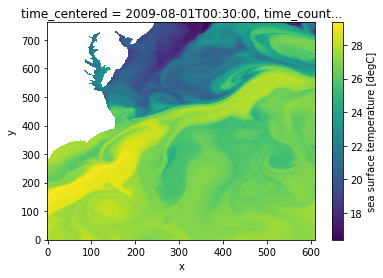

In [54]:
selected_data_set.isel(time_counter=0).sosstsst[coord_slice].plot()

## Grid

In [55]:
area = xr.DataArray((selected_data_set.e1t[coord_slice] * selected_data_set.e2t[coord_slice]), dims=['y','x'],
                   coords={'y':np.arange(len(selected_data_set.y[y_slice])),
                           'x':np.arange(len(selected_data_set.x[x_slice]))}
                  ).load()
# area.plot()

Spacings:

In [56]:
dxw = xr.DataArray(selected_data_set.e1u[coord_slice], dims=['y','x'],
                   coords={'y':np.arange(len(selected_data_set.y[y_slice])),
                           'x':np.arange(len(selected_data_set.x[x_slice]))}
                  ).load() # x-spacing centered at western cell edge

dyw = xr.DataArray(selected_data_set.e2u[coord_slice], dims=['y','x'],
                   coords={'y':np.arange(len(selected_data_set.y[y_slice])),
                           'x':np.arange(len(selected_data_set.x[x_slice]))}
                  ).load() # y-spacing centered at western cell edge

dxs = xr.DataArray(selected_data_set.e1v[coord_slice], dims=['y','x'],
                   coords={'y':np.arange(len(selected_data_set.y[y_slice])),
                           'x':np.arange(len(selected_data_set.x[x_slice]))}
                  ).load() # x-spacing centered at southern cell edge

dys = xr.DataArray(selected_data_set.e2v[coord_slice], dims=['y','x'],
                   coords={'y':np.arange(len(selected_data_set.y[y_slice])),
                           'x':np.arange(len(selected_data_set.x[x_slice]))}
                  ).load() # y-spacing centered at southern cell edge

In [57]:
dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min())
dx_min = dx_min.values
dx_min

array(1289.53776172)

Diffusivities for thefilter in the east-west and north-south directions

In [58]:
kappa_w = xr.ones_like(dxw)
kappa_s = xr.ones_like(dxw)

## Mask

In [59]:
wet_mask = xr.DataArray(selected_data_set.umask[coord_slice],
                        dims=['y','x'],
                        coords={'y':np.arange(len(selected_data_set.y[y_slice])),
                           'x':np.arange(len(selected_data_set.x[x_slice]))}).load()

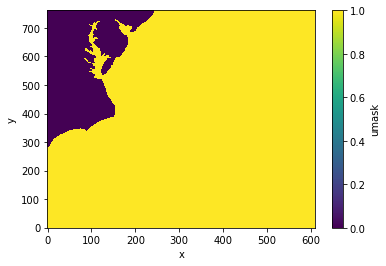

In [60]:
wet_mask.plot()

## High-resolution dataset

In [61]:
dataHR = xr.Dataset({"sst" : selected_data_set.sosstsst[data_slice],
                     "sal" : selected_data_set.sosaline[data_slice],
                     "wet_mask" : wet_mask},
                    coords=selected_data_set[data_slice].coords)

# Filter

## Define filter

Parameters (to determine) :

In [62]:
filter_scale = 30000

In [63]:
gaussian_filter = gcm_filters.Filter(
    filter_scale=filter_scale,    
    dx_min=dx_min,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={
        'wet_mask': wet_mask, 
        'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
        'kappa_w': kappa_w, 'kappa_s': kappa_s
    }
)

In [64]:
# gaussian_filter = gcm_filters.Filter(
#     filter_scale=6,   # 12 grid cells
#     dx_min=1,
#     filter_shape=gcm_filters.FilterShape.GAUSSIAN,
#     grid_type=gcm_filters.GridType.REGULAR_WITH_LAND,
#     grid_vars={
#         'wet_mask': wet_mask
#     }
# )

## Apply filter to data

In [65]:
# intermediate dataset: HR data + filtering (result has still the spatial resoltion if HR data)
data_filtered = xr.Dataset({}, coords=selected_data_set[data_slice].coords)

"Lazy" filter execution with Dask

In [66]:
data_filtered["sst"] = gaussian_filter.apply(dataHR.sst, dims=['y', 'x'])
data_filtered["sal"] = gaussian_filter.apply(dataHR.sal, dims=['y', 'x'])

# Spatial coarsening (downsampling)

In [67]:
coarsen_window_size=12

In [68]:
# def downsample(data, window_size) :
#     return data.coarsen(x=window_size, boundary='pad').mean().coarsen(y=window_size,boundary='pad').mean()*
def downsample(data, window_size, area_2d, wet_mask) :
    area_masked = area_2d*wet_mask
    data_weighted = area_masked*data
    data_weighted_sums = data_weighted.coarsen(x=coarsen_window_size, y=coarsen_window_size, boundary='trim', \
                                           coord_func={'x':'mean', 'y':'mean', 'lat':'mean', 'lon':'mean','e1t':'sum', 'e2t':'sum'}).sum(skipna=False)
    area_window_sums = area_masked.coarsen(x=coarsen_window_size, y=coarsen_window_size, boundary='trim').sum(skipna=False)
    result = data_weighted_sums/area_window_sums
    result['x'] = np.arange(len(result['x']))
    result['y'] = np.arange(len(result['y']))
    
    # coarsened coordinates:
    new_e1t = data['e1t'].coarsen(x=coarsen_window_size,boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).mean(skipna=False).coarsen(y=coarsen_window_size, boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).sum(skipna=False).\
drop(['depth', 'e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'])
    print(new_e1t)
    new_e2t = data['e2t'].coarsen(x=coarsen_window_size,boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).mean(skipna=False).coarsen(y=coarsen_window_size, boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).sum(skipna=False).\
drop(['depth', 'e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'])
    result['e1t'] = (['y','x'], new_e1t.values) 
    result['e2t'] = (['y','x'], new_e2t.values) 
    return result

In [69]:
dataLR = downsample(data_filtered, coarsen_window_size, area, wet_mask)

<xarray.DataArray 'e1t' (y: 63, x: 50)>
dask.array<sum-aggregate, shape=(63, 50), dtype=float64, chunksize=(63, 50), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) int64 66 210 354 498 642 786 ... 8274 8418 8562 8706 8850 8994
  * x        (x) int64 66 210 354 498 642 786 ... 6402 6546 6690 6834 6978 7122


In [70]:
# choose the index of time_counter for 2D spatial plots
it = [0]

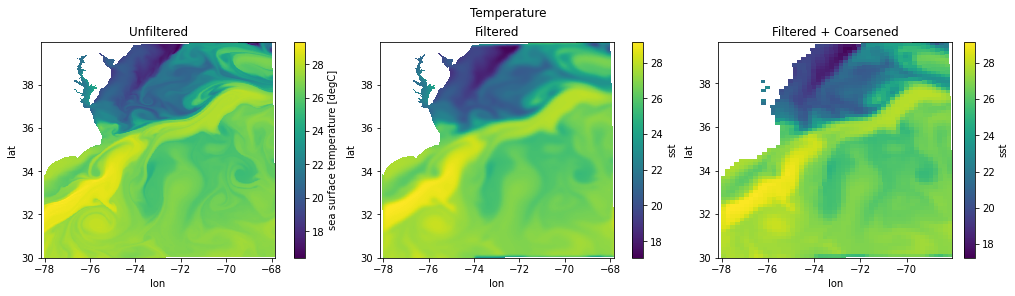

In [71]:
fig, ax = plt.subplots(ncols=3, constrained_layout=True, figsize=(14,4))
fig.suptitle('Temperature')
(dataHR.isel(time_counter=it)).sst.plot(ax=ax[0],x='lon', y='lat')
ax[0].set(title=r'Unfiltered')
(data_filtered.isel(time_counter=it)).sst.plot(ax=ax[1],x='lon', y='lat')
#ax[1].pcolormesh(dataset_filtered.lon, dataset_filtered.lat, dataset_filtered.sst.compute())
ax[1].set(title=r'Filtered')
(dataLR.isel(time_counter=it)).sst.plot(ax=ax[2], x='lon', y='lat')
ax[2].set(title=r'Filtered + Coarsened')
plt.show()

In [80]:
dataLR

<xarray.Dataset>
Dimensions:        (time_counter: 2207, x: 50, y: 63)
Coordinates: (12/17)
  * y              (y) int64 0 1 2 3 4 5 6 7 8 9 ... 54 55 56 57 58 59 60 61 62
  * x              (x) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
    e1f            (y, x) float64 dask.array<chunksize=(63, 50), meta=np.ndarray>
    e1t            (y, x) float64 1.924e+04 1.924e+04 ... 1.707e+04 1.707e+04
    e1u            (y, x) float64 dask.array<chunksize=(63, 50), meta=np.ndarray>
    e1v            (y, x) float64 dask.array<chunksize=(63, 50), meta=np.ndarray>
    ...             ...
    lon            (y, x) float32 dask.array<chunksize=(63, 50), meta=np.ndarray>
    nav_lat        (y, x) float32 dask.array<chunksize=(63, 50), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(63, 50), meta=np.ndarray>
    depth          (y, x) float32 dask.array<chunksize=(63, 50), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 2009-08-01T00:30:00 ... 2009...
    time_centered  (time_counter) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
Data variables:
    sst            (y, x, time_counter) float64 dask.array<chunksize=(63, 50, 1), meta=np.ndarray>
    sal            (y, x, time_counter) float64 dask.array<chunksize=(63, 50, 1), meta=np.ndarray>

# Spatial spectra

## Interpolation on a spatially uniform grid 

In [72]:
def uniform_grid_interpolation(data) :
    # first fill in nans
    data_filled_nans = data.interpolate_na(dim="x", method="linear")
    data_filled_nans = data_filled_nans.interpolate_na(dim="y", method="linear")
    data_filled_nans = data_filled_nans.interpolate_na(dim="x", method="nearest", fill_value="extrapolate")
    
    # transform coordinates to uniform spacings
    delta_x_min_m = data['e1t'].min().values
    delta_y_min_m = data['e2t'].min().values
    delta_min = np.min([delta_x_min_m, delta_y_min_m])
    new_x = np.cumsum(delta_min/data['e1t'], axis=1)
    new_y = np.cumsum(delta_min/data['e2t'], axis=0)
    interpolated_field = data_filled_nans.interp(x=new_x, y=new_y).\
drop(['depth', 'e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'])
    interpolated_field.attrs['delta_min'] = delta_min
    return interpolated_field

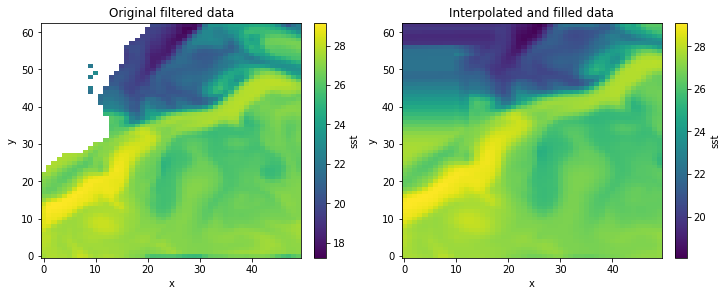

In [73]:
fig, ax = plt.subplots(ncols=2, constrained_layout=True, figsize=(10,4))
(dataLR.isel(time_counter=it)).sst.plot(ax=ax[0])
(uniform_grid_interpolation(dataLR).isel(time_counter=it)).sst.plot(ax=ax[1])
ax[0].set(title='Original filtered data')
ax[1].set(title='Interpolated and filled data')
plt.show()

## Isotropic power spectra

In [74]:
def wrapper_xrtf_isotropic_PS(data, variable, binning_factor=4) :
    interpolated_data = uniform_grid_interpolation(data[variable])
    isotropic_power_spec = xrft_module.isotropic_power_spectrum(interpolated_data, dim=['x','y'], detrend='linear',scaling="spectrum", nfactor=4, truncate=True)
    Nmin = min([len(data['x']), len(data['y'])])
    isotropic_power_spec.coords['wavenumber'] = ('freq_r', isotropic_power_spec['freq_r']/(Nmin*interpolated_data.attrs['delta_min']*0.001))
    return isotropic_power_spec.rename('Spatial spectrum')

In [75]:
spec_temp_variance_HR = wrapper_xrtf_isotropic_PS(dataHR, 'sst', binning_factor = 4)
%time mean_spec_temp_variance_HR = spec_temp_variance_HR.mean(dim='time_counter').compute()

CPU times: user 38min 30s, sys: 32min 54s, total: 1h 11min 24s
Wall time: 23min 56s


In [76]:
spec_temp_variance_filtered = wrapper_xrtf_isotropic_PS(data_filtered, 'sst', binning_factor = 4)
%time mean_spec_temp_variance_filtered = spec_temp_variance_filtered.mean(dim='time_counter').compute()

CPU times: user 1h 13min, sys: 34min 24s, total: 1h 47min 25s
Wall time: 31min 23s


In [77]:
spec_temp_variance_LR = wrapper_xrtf_isotropic_PS(dataLR, 'sst', binning_factor = 2)
%time mean_spec_temp_variance_LR = spec_temp_variance_LR.mean(dim='time_counter').compute()

CPU times: user 33min 1s, sys: 54 s, total: 33min 55s
Wall time: 5min 58s


In [78]:
mean_spec_temp_variance_LR.to_netcdf("Data/region1_filter_30km_coarse_12/mean_spec_temp_variance_LR_summer.nc")
mean_spec_temp_variance_filtered.to_netcdf("Data/region1_filter_30km_coarse_12/mean_spec_temp_variance_filtered_summer.nc")
mean_spec_temp_variance_HR.to_netcdf("Data/region1_filter_30km_coarse_12/mean_spec_temp_variance_HR_summer.nc")

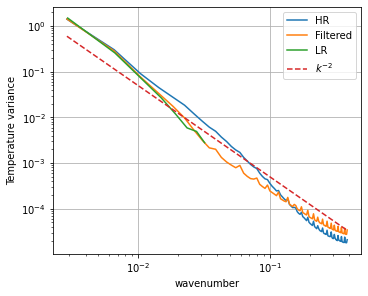

In [79]:
fig, ax = plt.subplots(ncols=1, constrained_layout=True, figsize=(5,4))
mean_spec_temp_variance_HR.plot(x='wavenumber', ax=ax, ls='-', marker='', label='HR')
mean_spec_temp_variance_filtered.plot(x='wavenumber', ax=ax, ls='-', marker='', label='Filtered')
mean_spec_temp_variance_LR.plot(x='wavenumber', ax=ax, ls='-', marker='', label='LR')
ax.plot(mean_spec_temp_variance_HR['wavenumber'], 5e-6*mean_spec_temp_variance_HR['wavenumber']**(-2),ls='--', label=r'$k^{-2}$')
ax.set(yscale='log', xscale='log', ylabel='Temperature variance')
ax.grid(True)
ax.legend()
plt.show()